In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import glob

from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
from utils import hamilton_detector, christov_detector, findpeaks, engzee_detector
from ecg_detectors.ecgdetectors import Detectors, MWA, panPeakDetect, searchBack

np.random.seed(256)

warnings.filterwarnings('ignore')

In [2]:
data_path = 'Part_A_S/biosignals_filtered/*/'
all_files = glob.glob(data_path + '/*.csv')
one_file = ''
for file in all_files[0:len(all_files)]:
    if file == 'Part_A_S/biosignals_filtered/091809_w_43/091809_w_43-PA4-023_bio.csv':
        one_file = file
one_file

'Part_A_S/biosignals_filtered/091809_w_43/091809_w_43-PA4-023_bio.csv'

In [3]:
df = pd.read_csv(one_file, sep='\t', header=0, index_col=None)
ecg_data = df[['time', 'ecg']]
ecg_data

,time,ecg
0,391,-124.945800
1,2344,-138.602200
2,4297,-128.055700
3,6250,-114.843800
4,8203,-120.054800
...,...,...
2811,5490625,61.109270
2812,5492578,43.857540
2813,5494531,-4.861115
2814,5496484,-14.621150


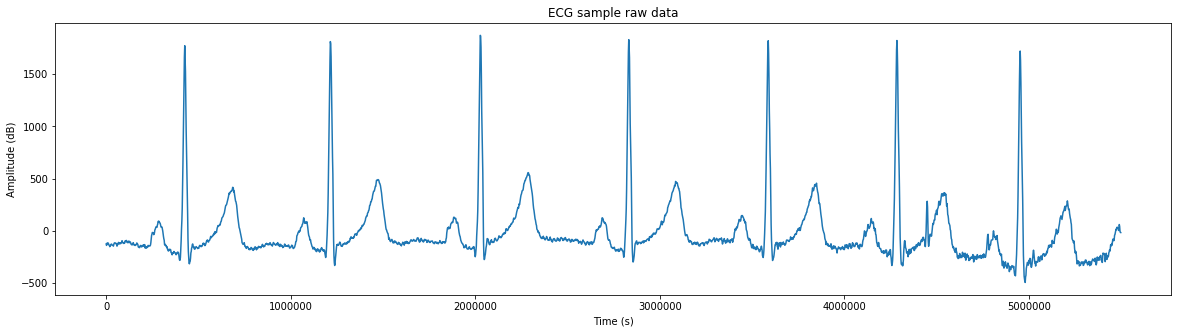

In [4]:
plt.figure(figsize=(20, 5))
plt.ylabel("Amplitude (dB)")
fs = 200
# Calculate time values in seconds
times = ecg_data['time'].values
data = ecg_data['ecg'].values
plt.plot(times, data)
plt.xlabel("Time (s)")
plt.title("ECG sample raw data")
plt.show()

In [5]:
#%%pixie_debugger
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,
                data)  # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
    return y


def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi * data[0])
    return sos, z, zi


def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi * z[0])
    return z2


def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,
                    data)  # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    return y

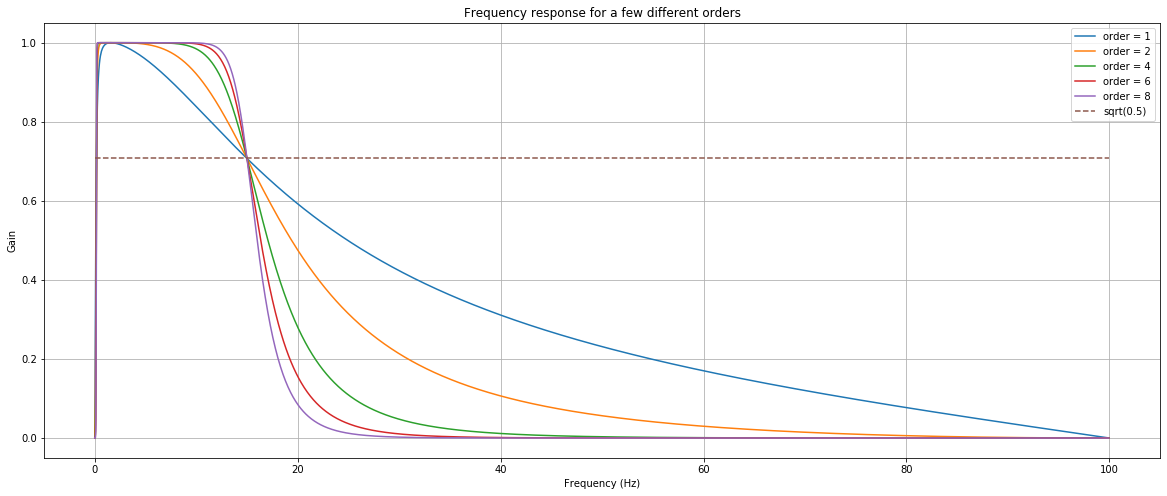

In [6]:
# Sample rate and desired cutoff frequencies (in Hz).
x = data
fs = 200  # corresponds to 60 beats per min (normal for human), assumed.
lowcut = 0.05 * 3.3  # 9.9 beats per min
highcut = 15  # 900 beats per min

# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         "--", label="sqrt(0.5)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.title("Frequency response for a few different orders")
plt.grid(True)
plt.legend(loc="best")

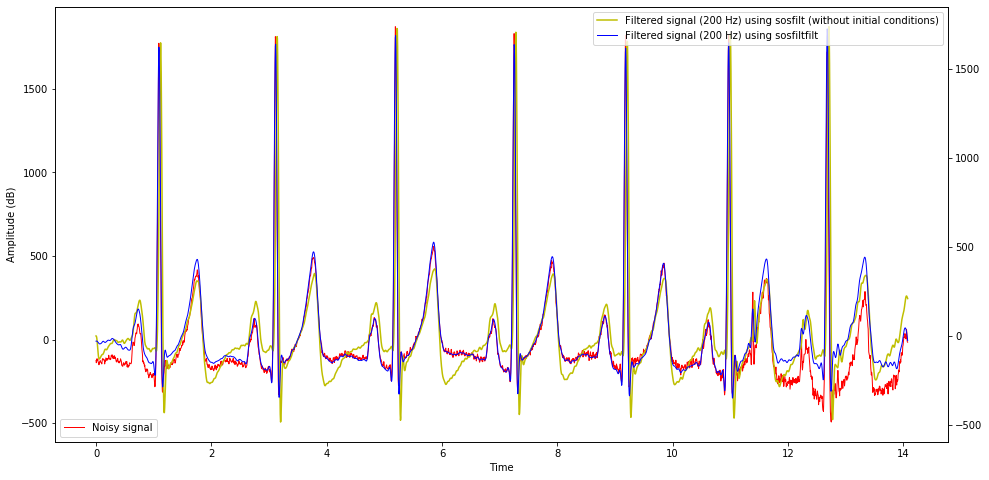

In [7]:
#%%pixie_debugger
plt.figure(2, figsize=(16, 8))
plt.clf()
plt.ylabel("Amplitude (dB)")
plt.xlabel("Time")
times = np.arange(data.shape[0], dtype='float')
plt.plot(times/fs, x, "r", linewidth=1, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times/fs, butter_bandpass_filter(x, lowcut, highcut, fs, order=4), 'y',
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(times/fs, y, 'b', linewidth=1, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)

plt.axis("tight")
plt.legend(loc="upper right")
plt.savefig('filter_ECG.pdf')